# Introduction

This notebook attempts to improve the score from `yu_roger-10906675-week1_randcv_xgb_69051.ipynb` of 0.69051 by using a probability calibrated classifier.

## Summary
* [Calibration with early stopping](#Conclusion:-Calibration-with-early-stopping) does not improve the validation AUC compared to pure early stopping.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.make_dataset import load_sets, save_sets, save_predictions
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [5]:
competition = os.environ['COMPETITION']

# Set up directories

In [6]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [7]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')
df_test = pd.read_csv(raw_data_dir / 'test.csv')
X_train = pd.read_csv(interim_data_dir / 'X_train.csv')
X_val = pd.read_csv(interim_data_dir / 'X_val.csv')
y_train = pd.read_csv(interim_data_dir / 'y_train.csv').squeeze()
y_val = pd.read_csv(interim_data_dir / 'y_val.csv').squeeze()
X_test = pd.read_csv(interim_data_dir / 'X_test.csv')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

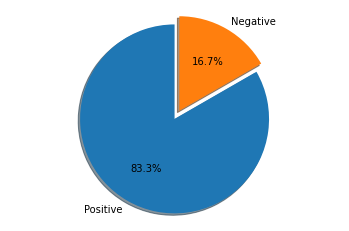

In [8]:
plot_pie(y_train)

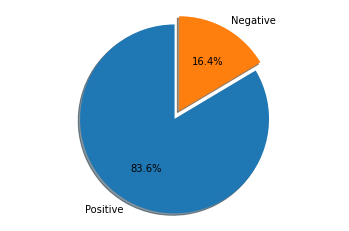

In [9]:
plot_pie(y_val)

## Baseline Score

The baseline is simply the best from the previous attempt of 0.69051.

# `CalibratedClassifierCV` from scratch

## Full data set

In [10]:
X_train, X_val, y_train, y_val, X_test = load_sets(interim_data_dir)

In [11]:
base_estimator = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = CalibratedClassifierCV(base_estimator=base_estimator, cv=5, n_jobs=-1)

clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    eval_metric='logloss',
                                                    gamma=None, gpu_id=None,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                         

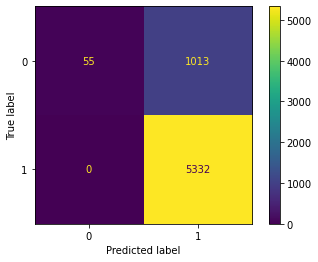

In [12]:
preds = clf.predict(X_train)
plot_confusion_matrix(estimator=clf, X=X_train, y_true=y_train)

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  55 1013]
 [   0 5332]]
Accuracy:  0.84171875
AUC:  0.9998656616401291
              precision    recall  f1-score   support

           0       1.00      0.05      0.10      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.92      0.53      0.51      6400
weighted avg       0.87      0.84      0.78      6400



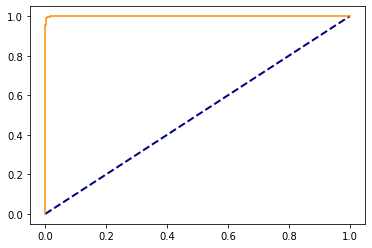

In [13]:
classification_reports(clf, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   1  262]
 [   0 1337]]
Accuracy:  0.83625
AUC:  0.6653793323114288
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.92      0.50      0.46      1600
weighted avg       0.86      0.84      0.76      1600



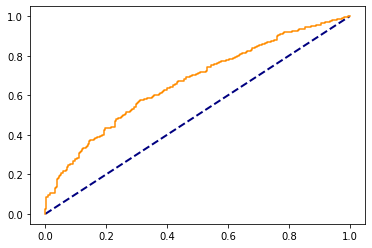

In [14]:
classification_reports(clf, X_val, y_val)

## Reduced data set

In [15]:
X_train_lim, X_val_lim, y_train_lim, y_val_lim, X_test_lim = load_sets(interim_data_dir, suffix='top_8_features')

In [16]:
base_estimator = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = CalibratedClassifierCV(base_estimator=base_estimator, cv=5, n_jobs=-1)

clf.fit(X_train_lim, y_train_lim)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    eval_metric='logloss',
                                                    gamma=None, gpu_id=None,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                         

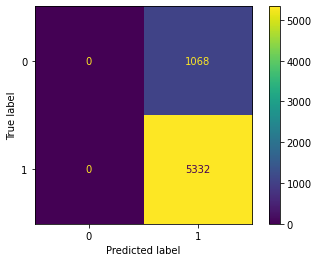

In [17]:
preds = clf.predict(X_train_lim)
plot_confusion_matrix(estimator=clf, X=X_train_lim, y_true=y_train_lim)

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[   0 1068]
 [   0 5332]]
Accuracy:  0.833125
AUC:  0.994050654517562
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1068
           1       0.83      1.00      0.91      5332

    accuracy                           0.83      6400
   macro avg       0.42      0.50      0.45      6400
weighted avg       0.69      0.83      0.76      6400



c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

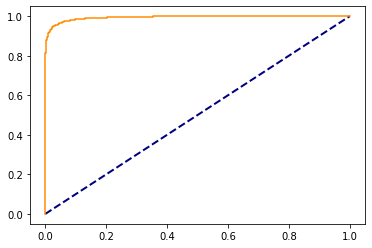

In [18]:
classification_reports(clf, X_train_lim, y_train_lim)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   0  263]
 [   0 1337]]
Accuracy:  0.835625
AUC:  0.6378732250569489
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.42      0.50      0.46      1600
weighted avg       0.70      0.84      0.76      1600



c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

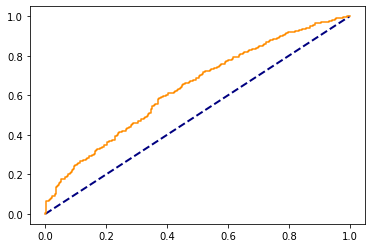

In [19]:
classification_reports(clf, X_val_lim, y_val_lim)

## Conclusion: `CalibratedClassifierCV` from scratch

Calibration of probabilities did not improve the  validation AUC, which decreased to 0.638. Furthermore, the bias towards predictions of the positive class is at its most extreme, with all predictions being the positive class.

# `CalibratedClassifierCV` from pretrained

The pretrained aspect is to the extent of the `best_ntree_limit` value that was found in the early stopping exercise. The early stopping model has the `best_ntree_limit` value of 4, which is used as the `n_estimators` parameter. The parameters from that model is loaded and a new classifier is instantiated with these parameters. This is because sklearn CV objects can't handle extra XGB parameter in the fitting stage.

In [20]:
prefit_model = load(models_dir / 'xgb_top_8_features_early_stopping.joblib')

In [21]:
params = prefit_model.get_xgb_params()
# params['n_estimators'] = prefit_model.get_booster().best_ntree_limit
params['n_estimators'] = 10
params['use_label_encoder'] = False
params

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss',
 'n_estimators': 10,
 'use_label_encoder': False}

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  21 1047]
 [   0 5332]]
Accuracy:  0.83640625
AUC:  0.8173149326657507
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.92      0.51      0.47      6400
weighted avg       0.86      0.84      0.77      6400



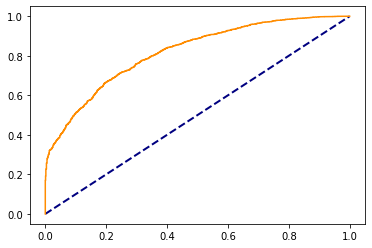

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   1  262]
 [   3 1334]]
Accuracy:  0.834375
AUC:  0.6773293594705814
              precision    recall  f1-score   support

           0       0.25      0.00      0.01       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.54      0.50      0.46      1600
weighted avg       0.74      0.83      0.76      1600



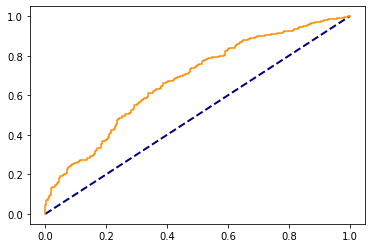

In [22]:
clf = CalibratedClassifierCV(base_estimator=xgb.XGBClassifier(**params))

clf.fit(X_train_lim, y_train_lim)

preds_train = clf.predict(X_train_lim)
probs_train = clf.predict_proba(X_train_lim)[:, 1]
preds_val = clf.predict(X_val_lim)
probs_val = clf.predict_proba(X_val_lim)[:, 1]

classification_reports_2(y_train, preds_train, probs_train)
classification_reports_2(y_val, preds_val, probs_val)

In [23]:
plot_confusion_matrix(clf, X_val, y_val)

XGBoostError: [21:24:54] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1183: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (8 vs. 19) : Number of columns does not match number of features in booster.

## Conclusion: Calibration with early stopping

Adding calibration doesn't improve the mere early stopping model; validation AUC dropped from 0.685 to 0.677.